In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from gensim import corpora, models, similarities
from gensim.models import Phrases
from gensim.models.phrases import Phraser

## Load and Explore Training Data

In [3]:
df_train = pd.read_table('data/TrainingSet.txt', sep='\t')

In [4]:
# transform date and fillna 
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d.%m.%Y').dt.date
df_train['Event ID'] = df_train['Event ID'].fillna(-1)

In [5]:
df_train.head()

,Date,Time,Trainig/Test,Event ID,Title,Link,Abstract
0,2019-02-05,18:45:44,Training,1.0,New dog food recall and latest warning on grai...,https://twitter.com/tweet/status/1092857075753...,New dog food recall and latest warning on grai...
1,2019-02-05,06:29:38,Training,1.0,New Dog Food Recall And The Latest Warning On ...,https://twitter.com/tweet/status/1092671572400...,New Dog Food Recall And The Latest Warning On ...
2,2019-02-05,18:40:20,Training,1.0,RT @BaybeeReade: Another dog food recall over ...,https://twitter.com/tweet/status/1092855599233...,RT @BaybeeReade: Another dog food recall over ...
3,2019-02-04,22:05:19,Training,1.0,Hill’s Pet Nutrition voluntary recall affects ...,https://twitter.com/tweet/status/1092544879400...,Hill’s Pet Nutrition voluntary recall affects ...
4,2019-02-05,08:53:45,Training,1.0,RT @mercnews: New dog food recall and the late...,https://twitter.com/tweet/status/1092707841809...,RT @mercnews: New dog food recall and the late...


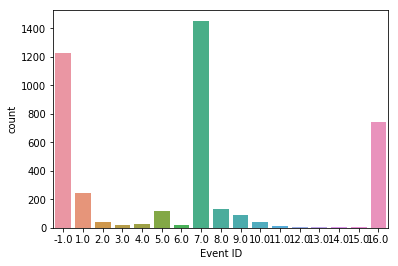

In [6]:
# visualization
sns.countplot(x='Event ID', data=df_train)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

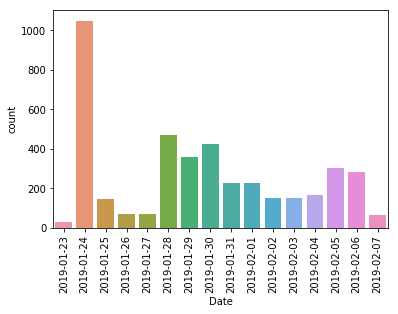

In [7]:
sns.countplot(x='Date', data=df_train, order = sorted(set(df_train['Date'])))
plt.xticks(rotation=90)

## NLP

In [8]:
df_train['Abstract'].head()

0    New dog food recall and latest warning on grai...
1    New Dog Food Recall And The Latest Warning On ...
2    RT @BaybeeReade: Another dog food recall over ...
3    Hill’s Pet Nutrition voluntary recall affects ...
4    RT @mercnews: New dog food recall and the late...
Name: Abstract, dtype: object

In [9]:
stoplist = set(stopwords.words('english'))

### Tokenize and Remove Stopwords

In [10]:
def tokenize_and_filter_stopwords(raw_text):
    raw_text = str(raw_text)
    tokens = wordpunct_tokenize(raw_text)
    text = nltk.Text(tokens)
    words = [w.lower() for w in text if w.isalpha()]
    words = [word for word in words if word not in stoplist]

    return words

In [11]:
df_train['ab_clean'] = df_train['Abstract'].apply(tokenize_and_filter_stopwords)

In [12]:
df_train[['Abstract', 'ab_clean']].head()

,Abstract,ab_clean
0,New dog food recall and latest warning on grai...,"[new, dog, food, recall, latest, warning, grai..."
1,New Dog Food Recall And The Latest Warning On ...,"[new, dog, food, recall, latest, warning, grai..."
2,RT @BaybeeReade: Another dog food recall over ...,"[rt, baybeereade, another, dog, food, recall, ..."
3,Hill’s Pet Nutrition voluntary recall affects ...,"[hill, pet, nutrition, voluntary, recall, affe..."
4,RT @mercnews: New dog food recall and the late...,"[rt, mercnews, new, dog, food, recall, latest,..."


## Phrase Model

In [13]:
bigram_model = Phraser(Phrases(df_train['ab_clean']))
df_train['ab_clean_ph'] = df_train['ab_clean'].apply(lambda text: bigram_model[text])
df_train[['Abstract','ab_clean','ab_clean_ph']].head()

,Abstract,ab_clean,ab_clean_ph
0,New dog food recall and latest warning on grai...,"[new, dog, food, recall, latest, warning, grai...","[new, dog_food, recall, latest_warning, grain_..."
1,New Dog Food Recall And The Latest Warning On ...,"[new, dog, food, recall, latest, warning, grai...","[new, dog_food, recall, latest_warning, grain_..."
2,RT @BaybeeReade: Another dog food recall over ...,"[rt, baybeereade, another, dog, food, recall, ...","[rt, baybeereade, another_dog, food, recall, d..."
3,Hill’s Pet Nutrition voluntary recall affects ...,"[hill, pet, nutrition, voluntary, recall, affe...","[hill_pet, nutrition, voluntary, recall_affect..."
4,RT @mercnews: New dog food recall and the late...,"[rt, mercnews, new, dog, food, recall, latest,...","[rt, mercnews, new, dog_food, recall, latest_w..."


In [14]:
# 取出有标签的作为验证
df_val = df_train[df_train['Event ID'] > 0]

## Self_Training Model

In [15]:
def split_lab_unlabel(df):
    '''分割有标签和无标签数据集'''
    label_ds = df[df['Event ID'] > 0 ]
    unlabel_ds = df[df['Event ID'] < 0]
    
    return label_ds, unlabel_ds

In [16]:
def concat_ds(train, test):
    '''堆叠旧的训练集和新的训练集'''
    train_u = train
    train_d = test[test['Event ID'] > 0]
    new_train = pd.concat([train_u,train_d], ignore_index=True)
    new_test = test
    
    return new_train, new_test

In [17]:
def tf_idf(df):
    vectorizer = TfidfVectorizer(min_df=2, max_features=1000)
    text_tfidf = vectorizer.fit_transform([' '.join(text) for text in df['ab_clean']])
    X = text_tfidf
    y = df['Event ID']
    return X, y

In [41]:
def lr_tune_param(X_train, y_train):
    '''参数调整'''
    param_test_lr =  {'C' :[10 ** x for x in list(range(-4,5,1))]}
    gsearch_lr = GridSearchCV(estimator = LogisticRegression( 
        penalty='l1', 
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced'
    ),                   
    param_grid = param_test_lr, 
    cv = 5,
    n_jobs = 4)

    gsearch_lr.fit(X_train,y_train)
    param = gsearch_lr.best_params_
    C = param['C']
    
    return C

In [19]:
def apply_lr_model(C, X_train, y_train, X_test):
    '''
    将LR模型应用于unlabel得到结果
    '''
    lr_model = LogisticRegression(
        penalty='l1',
        C=C,
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced').fit(X_train,y_train)
    predictions = lr_model.predict(X_test)
    score = lr_model.score(X_train, y_train)
    
    return predictions

In [55]:
def svm_tune_param(X_train, y_train):
    '''参数调整'''
    param_test_svm =  {'C' :[x for x in list(range(1,5,1))]}
    gsearch_svm = GridSearchCV(estimator = svm.LinearSVC( 
        penalty='l2', 
        loss='hinge',
        tol=0.000001
    ),                   
    param_grid = param_test_svm, 
    cv = 5,
    n_jobs = 4)

    gsearch_svm.fit(X_train,y_train)
    param = gsearch_svm.best_params_
    C = param['C']
    
    return C

In [44]:
def apply_svm_model(C, X_train, y_train, X_test):
    '''
    将SVM模型应用于unlabel得到结果
    '''
    svm_model = svm.LinearSVC(
        penalty='l2',
        C=C,
        loss='hinge',
        tol=0.000001).fit(X_train,y_train)
    predictions = svm_model.predict(X_test)
    score = svm_model.score(X_train, y_train)
    
    return predictions

In [20]:
def self_training(df_train):
    '''自学习训练'''
    label_ds,unlabel_ds = split_lab_unlabel(df_train)
    while unlabel_ds.shape[0] > 0:
        X_train, y_train = tf_idf(label_ds)
        uX_test, uy_test = tf_idf(unlabel_ds)
        C = lr_tune_param(X_train, y_train)
        predictions = apply_lr_model(C, X_train, y_train, uX_test)
        unlabel_ds['Event ID'] = predictions
        new_label_ds, unlabel_ds = split_lab_unlabel(unlabel_ds)
        label_ds = concat_ds(label_ds, new_label_ds)
        
    return label_ds  

In [45]:
def svm_self_training(df_train):
    '''自学习训练'''
    label_ds,unlabel_ds = split_lab_unlabel(df_train)
    while unlabel_ds.shape[0] > 0:
        X_train, y_train = tf_idf(label_ds)
        uX_test, uy_test = tf_idf(unlabel_ds)
        C = svm_tune_param(X_train, y_train)
        predictions = apply_svm_model(C, X_train, y_train, uX_test)
        unlabel_ds['Event ID'] = predictions
        new_label_ds, unlabel_ds = split_lab_unlabel(unlabel_ds)
        label_ds = concat_ds(label_ds, new_label_ds)
        
    return label_ds  

### Generate New Training Set and Model

#### LogisticRegression

In [21]:
new_train = self_training(df_train)

/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/suhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
new_train = new_train[0]

In [23]:
new_Xtrain, new_ytrain = tf_idf(new_train)

In [24]:
C = tune_param(new_Xtrain, new_ytrain)
print(C)

/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


10


In [25]:
lr_model = LogisticRegression(
        penalty='l1',
        C=10,
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced').fit(new_Xtrain, new_ytrain)

### SVM

In [58]:
svm_new_train = svm_self_training(df_train)

/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/suhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

In [59]:
svm_new_train = svm_new_train[0]

In [62]:
svm_new_Xtrain, svm_new_ytrain = tf_idf(svm_new_train)

In [63]:
C = svm_tune_param(svm_new_Xtrain, svm_new_ytrain)
print(C)

2


/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [65]:
svm_model = svm.LinearSVC(
        penalty='l2',
        C=2,
        loss='hinge',
        tol=0.000001).fit(svm_new_Xtrain, svm_new_ytrain)

/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Validation 

In [26]:
X_val, y_val = tf_idf(df_val)

In [27]:
val_score = lr_model.score(X_val, y_val)
print(val_score)

0.3333333333333333


In [66]:
svm_val_score = svm_model.score(X_val, y_val)
print(svm_val_score)

0.4425287356321839


## Load Test Data

In [28]:
df_test = pd.read_table('data/TestSet.txt', sep='\t')

In [29]:
df_test['Date'] = pd.to_datetime(df_train['Date'], format='%Y.%m.%d').dt.date
df_test['Event ID'] = df_train['Event ID'].fillna(-1)

In [30]:
df_test.head()

,Date,Time,Training/Test,Title,Link,Abstract,Event ID
0,2019-02-05,23:59:31,Test,@pccs_heron Salmonella,https://twitter.com/tweet/status/1103807421800...,@pccs_heron Salmonella,1.0
1,2019-02-05,23:59:20,Test,@richardlanigan @trishgreenhalgh No. It's not ...,https://twitter.com/tweet/status/1103807373196...,@richardlanigan @trishgreenhalgh No. It's not ...,1.0
2,2019-02-05,23:59:02,Test,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,https://twitter.com/tweet/status/1103807299389...,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,1.0
3,2019-02-04,23:57:08,Test,20 percent of seafood is mislabeled! Global fo...,https://twitter.com/tweet/status/1103806821456...,20 percent of seafood is mislabeled! Global fo...,1.0
4,2019-02-05,23:56:52,Test,#EuropeanCourt decided that #foodsafety and #e...,https://twitter.com/tweet/status/1103806755656...,#EuropeanCourt decided that #foodsafety and #e...,1.0


In [31]:
df_test['ab_clean'] = df_test['Abstract'].apply(tokenize_and_filter_stopwords)

In [32]:
df_test[['Abstract', 'ab_clean']].head()

,Abstract,ab_clean
0,@pccs_heron Salmonella,[salmonella]
1,@richardlanigan @trishgreenhalgh No. It's not ...,"[richardlanigan, trishgreenhalgh, feaces, alon..."
2,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,"[patchouliw, beccicath, mavenofmayhem, swifton..."
3,20 percent of seafood is mislabeled! Global fo...,"[percent, seafood, mislabeled, global, food, s..."
4,#EuropeanCourt decided that #foodsafety and #e...,"[europeancourt, decided, foodsafety, environme..."


In [33]:
bigram_model_test = Phraser(Phrases(df_test['ab_clean']))
df_test['ab_clean_ph'] = df_test['ab_clean'].apply(lambda text: bigram_model_test[text])
df_test[['Abstract','ab_clean','ab_clean_ph']].head()

,Abstract,ab_clean,ab_clean_ph
0,@pccs_heron Salmonella,[salmonella],[salmonella]
1,@richardlanigan @trishgreenhalgh No. It's not ...,"[richardlanigan, trishgreenhalgh, feaces, alon...","[richardlanigan, trishgreenhalgh, feaces, alon..."
2,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,"[patchouliw, beccicath, mavenofmayhem, swifton...","[patchouliw, beccicath, mavenofmayhem, swifton..."
3,20 percent of seafood is mislabeled! Global fo...,"[percent, seafood, mislabeled, global, food, s...","[percent, seafood, mislabeled, global, food_sa..."
4,#EuropeanCourt decided that #foodsafety and #e...,"[europeancourt, decided, foodsafety, environme...","[europeancourt, decided, foodsafety, environme..."


### Fit model on test set

In [34]:
X_test, y_test = tf_idf(df_test)

In [67]:
predictions = svm_model.predict(X_test)

In [68]:
score = svm_model.score(new_Xtrain, new_ytrain)
print(score)

0.9452546019603155


In [69]:
df_results = pd.read_table('data/sample_results.txt', sep='\t')

In [70]:
df_results['Event ID'] = predictions
df_results.rename(columns={'Event ID':'Predicted Event ID'}, inplace=True)
df_results.to_csv('data/results.csv')